# CSII 2023 Exercise 05: LQG, Separation Principle and Stability margins

© 2024 ETH Zurich, Jacques Bianchi, Sofia Talleri, Timm Grigat, Kalle Laitinen, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for CS2-Bot Steering
The dynamics of the CS2-Bot are given by a simple unicycle model. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the CS2-Bot in the plane and $\theta$ is the angle of the CS2-Bot with respect to the x-axis. The input of the CS2-Bot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in a global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

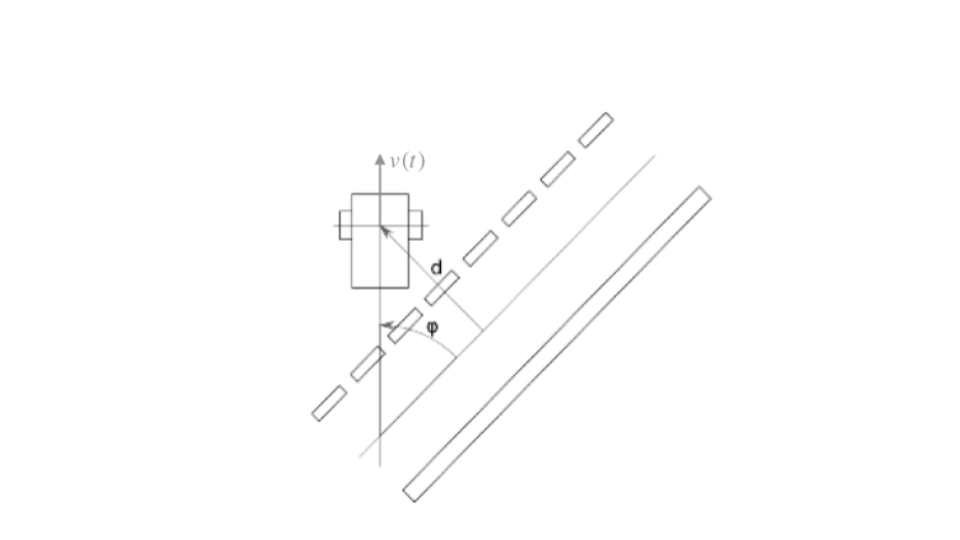

-------
# Installation
This first part is for setting up the system and is the same as the last notebook.

NOTE: The track type can be changed in the sub-section "Parameters and Reference Track" to allow multiple scenario testing!







We use the the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control` and the [CSII Python library](https://github.com/idsc-frazzoli/cs2solutions) `cs2solutions`, which can be installed using `pip`. It will also installed all other necessary packages. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.

If some of the solutions aren't working, try restarting the kernel of the notebook.

In [ ]:
# Install the required python library with pip
!pip install control
%pip install cs2solutions --upgrade

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [ ]:
# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the CS2-Bot are defined in the next cell.

In [ ]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega                   # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [ ]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: np.array,
               w_curvy: np.array,
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)

    plt.xlabel('y [m]')
    plt.ylabel('x [m]')
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t, y_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t, w_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: List[np.array],
               w_curvy: np.array,
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(t)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        if i == 0:
          legend_list.append('controller_without_noise')
        elif i == 1:
          legend_list.append('controller_with_noise')
        else:
          legend_list.append(f'controller_{i-1}')

    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)

    plt.xlabel('y [m]')
    plt.ylabel('x [m]')
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t[0], y_coord_ref)
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(t[i], y_ctr[i], linewidth=1)
        if i ==0:
          legend_list.append('controller_without_noise')
        elif i == 1:
          legend_list.append('controller_with_noise')
        else:
          legend_list.append(f'controller_{i-1}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t[0], w_curvy)
    for i in range(number_ctr):
        plt.plot(t[i], w_ctr[i], linewidth=1)
        if i ==0:
          legend_list.append('controller_without_noise')
        elif i == 1:
          legend_list.append('controller_with_noise')
        else:
          legend_list.append(f'controller_{i-1}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array,
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')

## Parameters and Reference Track

We set a default CS2-Bot velocity and generate the nonlinear system using the `control` library.

In [ ]:
# Default CS2-Bot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the CS2-Bot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

In [ ]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 35, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [ ]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D

-----------------

## Pole Placement

This is the pole placement function from last notebook. This time we only use the `control` library.

In [ ]:
def feedforward_kr_solution(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr

def place_poles_Ackermann(A: np.array, B: np.array, C: np.array,
                          D: float, poles: List):
    K = ct.acker(A,B,poles)
    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)

    kr = feedforward_kr_solution(A, B, C, K)

    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return K, kr, clsys

# Exercise 0: Noise

In this section we will use a Luenberger Observer to compensate noisy states and inputs, as we did in the last notebook. This time we will focus on gaussian noise. Choose the noise type which you would like to test in `index_noise`, where you change the integer number to the noise index you want test. Index `index_noise = 0` corresponds to a gaussian noise with low standard deviation, index `index_noise = 1` has a medium standard deviation, `index_noise = 2` has a high standard deviation, `index_noise = 3` corresponds to a constant noise (i.e. constant shift of the states), which is non-gaussian, `index_noise = 4` is  non-gaussian white noise, and `index_noise = 5` is no noise.

Hint: For this exercise, you don't have to write any code. We encourage you to test the implemented system and get familiar with the different track and noise types.


In [ ]:
noise_type = ['low', 'medium', 'high', 'constant', 'white_noise', 'no_noise']
index_noise = 1
noise = noise_type[index_noise]
if noise == 'low':
    n = np.random.normal(loc=0.0, scale=v0/3, size=r.shape)
elif noise=='medium':
    n = np.random.normal(loc=0.0, scale=v0, size=r.shape)
elif noise=='high':
    n = np.random.normal(loc=0.0, scale=v0*3, size=r.shape)
elif noise=='constant':
    n = np.ones(r.shape)*v0/2
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))
U_no_noise = np.concatenate((r, np.zeros(r.shape)))

## Simulation
In the next cell we code the whole state feedback control loop as an input output system. Take a look and try to understand the code.

In [ ]:
def state_noise(u: np.array) -> np.array:
    y = u[2] + u[1]
    theta = u[3] + u[1]
    return np.array([u[0], y, theta])

def state_feedback_controller(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return u

def plant(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    xdot = A @ x + B @ u
    return xdot

def plant_out(x: np.array, u: np.array) -> np.array:
    y = x
    return y

def get_closed_loop_io_system(io_system_params: dict) -> ct.NonlinearIOSystem:
  sys_n = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_noise(u),
      inputs=('r', 'n', 'y', 'theta'),
      outputs=('r', 'yn', 'thetan'),
      params=None,
      name='noise')

  sys_cont = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2'),
      outputs=('control'),
      params=io_system_params,
      name='controller')

  sys_dyn = ct.NonlinearIOSystem(
      lambda t, x, u, params: plant(x, u, params['A'], params['B']),
      lambda t, x, u, params: plant_out(x, u),
      inputs=('control',),
      outputs=('y', 'theta'),
      states=('x1', 'x2'),
      params=io_system_params,
      name='plant')

  io_closed = ct.interconnect(
    [sys_dyn, sys_cont, sys_n],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['controller.x1', 'noise.yn'],
      ['controller.x2', 'noise.thetan'],
      ['controller.reference', 'noise.r'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y']
    ],
    inplist=['noise.r', 'noise.n'],
    outlist=['plant.y', 'controller.control']
  )

  return io_closed

def simulate_sys(A: np.array, B: np.array, C: np.array,
                   t: np.array, U: np.array, X0: List,
                   poles: List) -> Tuple[np.array, np.array]:
                   K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                                    poles=poles)
                   io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr}
                   io_closed = get_closed_loop_io_system(io_system_params)
                   tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

                   return tp, yp

In the next cell you can choose your poles in poles and initial state x0 and simulate the system. The first system has no noise and the second system has your choosen noise.

In [ ]:
poles = [-0.3, -0.3] # Straight path
#poles = [-2, -2]  # Easy/Hard path
x0 = [0.2, 0.1]

# No Noise System
tp, yp = simulate_sys(A, B, C, t, U_no_noise, x0, poles)
# Effective System with Noise
tp_noise, yp_noise = simulate_sys(A, B, C, t, U, x0, poles)

t_list = [tp, tp_noise]
y_list = [yp[0], yp_noise[0]]
u_list = [yp[1], yp_noise[1]]
plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)

In real world application the previous controller is unfeasible (look at the angular velocity response).\
We will try a new approach in the next exercise, using an observer!

##Luenberger Observer

We use the Luenberger observer derived in the last notebook as a reference for the rest of the notebook. Analyze the performance of the observer in the various scenarios and conditions.

NOTE: For the simulation of different track types, the poles of observer and controller need to be changed!

In [ ]:
def state_noise_new(u: np.array) -> np.array:
    y = u[1] + u[0]
    theta = u[2] + u[0]
    return np.array([y, theta])

def estimator(x: np.array, u: np.array, A: np.array, B: np.array,
        C: np.array, D: np.array, L: np.array) -> np.array:
  x = np.expand_dims(x, axis=1)
  xdot = (A - L @ C) @ x + B * u[0]  + L*u[1]
  return xdot

def estimator_out(x: np.array, u: np.array) -> np.array:
    return x

def get_closed_loop_io_system(io_system_params: dict) -> ct.NonlinearIOSystem:
  sys_n = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_noise_new(u),
      inputs=('n', 'y', 'theta'),
      outputs=('yn', 'thetan'),
      params=None,
      name='noise')

  sys_cont = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2'),
      outputs=('control'),
      params=io_system_params,
      name='controller')

  sys_est = ct.NonlinearIOSystem(
    lambda t, x, u, params: estimator(x, u, params['A'], params['B'],
                                      params['C'], params['D'], params['L']),
    lambda t, x, u, params: estimator_out(x, u),
    inputs=('control', 'y', 'theta'),
    outputs=('y', 'theta'),
      states=('x1', 'x2'),
    params=io_system_params,
    name='estimator')

  sys_dyn = ct.NonlinearIOSystem(
      lambda t, x, u, params: plant(x, u, params['A'], params['B']),
      lambda t, x, u, params: plant_out(x, u),
      inputs=('control',),
      outputs=('y', 'theta'),
      states=('x1', 'x2'),
      params=io_system_params,
      name='plant')

  io_closed = ct.interconnect(
    [sys_dyn, sys_cont, sys_n, sys_est],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['controller.x1', 'estimator.y'],
      ['controller.x2', 'estimator.theta'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y'],
      ['estimator.control', 'controller.control'],
      ['estimator.y', 'noise.yn'],
      ['estimator.theta', 'noise.thetan']
    ],
    inplist=['controller.reference', 'noise.n'],
    outlist=['plant.y', 'controller.control']
  )

  return io_closed

def simulate_LO(A: np.array, B: np.array, C: np.array,
            t: np.array, U: np.array, X0: List,
            poles: List, poles_observer: List) -> Tuple[np.array, np.array]:
            K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                            poles=poles)
            L = ct.acker(A.T, C.T, poles_observer).T
            io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr, 'L': L}
            io_closed = get_closed_loop_io_system(io_system_params)

            tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

            return tp, yp

Now we would like to simulate the system with a state feedback controller and a Luenberger observer. In the next cell you can choose your controller poles in `poles_controller`, your observer poles in `poles_observer` and your initial state `x0`. The first two elements of `x0` are the `y` and `theta` initial states of the plant (true initial state) and the last two elments are the `y` and `theta` initial states of the estimator.

In [ ]:
poles_controller = [-0.3, -0.3] # Straight path
poles_observer = [-1, -1] # Straight path

#poles_controller = [-2, -2] # Easy/Hard path
#poles_observer = [-5, -5] # Easy/Hard path

x0 = [0.2, 0.1, 0.0, 0.0]

# No Noise System
tp, yp = simulate_LO(A, B, C, t, U_no_noise, x0, poles_controller, poles_observer)
# Effective System with Noise
tp_noise, yp_noise = simulate_LO(A, B, C, t, U, x0, poles_controller, poles_observer)

t_list = [tp, tp_noise]
y_list = [yp[0], yp_noise[0]]
u_list = [yp[1], yp_noise[1]]
plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)

# Exercise 1: Linear Quadratic Estimator (Kalman filter)

Kalman filter, also referred to as linear quadratic estimation (LQE), is a powerful algorithm merging statistics with control theory. It uses a sequence of obseved noisy measurements to generate estimates of the unknown state variables.

## Exercise 1.1
We want to build a Kalman Filter estimator. In the next cell implement the  Kalman estimator gain and try different value of process and sensor noise covariance matrices $QN$ and $RN$.

Hint: If your implementation reacts similarly to the Luenberger observer, you may have found the right parameters :)

In [ ]:
def kalman_filter_exercise(A: np.array, B: np.array, C: np.array) -> np.array:
    # TODO: write code
    sys = None

    #TODO QN & RN
    #Process and sensor noise covariance matrices
    QN = None
    RN = None

    #TODO Kalman estimator gain
    L = None

    return L

## Solution exercise 1.1




In [ ]:
def kalman_filter(A: np.array, B: np.array, C: np.array) -> np.array:

  #Process and sensor noise covariance matrices
  QN = np.cov(U, rowvar=True)[1, 1]
  RN = QN*10

  # If non gaussian-noise
  if QN == 0:
    QN = 1
    RN = 10

  #Kalman estimator gain
  L, P, E = ct.lqe(A, B, C, QN, RN)
  return L

##Test your implementation here

In [ ]:
io_test_ex = kalman_filter_exercise(A, B, C)
io_test_sol = kalman_filter(A, B, C)

if np.array_equal(io_test_ex, io_test_sol):
  print('Your Implementation is correct!')
  print(f'Solution: {io_test_sol}')
else:
  print(f'Your implementation: {io_test_ex}')
  print(f'Solution: {io_test_sol}')

## Simulation
Use the following code to simulate your filter performance.

NOTE: For the simulation of a different track type, the poles of the controller need to be changed!

In [ ]:
def simulate_kalman(A: np.array, B: np.array, C: np.array,
             t: np.array, U: np.array, X0: List[float],
             poles: List[float]) -> Tuple[np.array, np.array]:
    K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0, poles=poles)
    L = kalman_filter(A, B, C)
    io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr, 'L': L}
    io_closed = get_closed_loop_io_system(io_system_params)

    tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)
    return tp, yp

poles_controller = [-1, -1] # Straight path
#poles_controller = [-2, -2] # Easy/Hard path

x0 = [0.2, 0.1, 0.0, 0.0]

# Reference System: No Noise
tp, yp = simulate_kalman(A, B, C, t, U_no_noise, x0, poles_controller)
# System with Kalman Filter
tp_noise, yp_noise = simulate_kalman(A, B, C, t, U, x0, poles_controller)

t_list = [tp, tp_noise]
y_list = [yp[0], yp_noise[0]]
u_list = [yp[1], yp_noise[1]]
plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)

## Exercise 1.2

What can you say about the performance of the Kalman filter? How does it compare to the previous observer? How do noise parameters affect the performance?


Write here your answer:

## Solution exercise 1.2

The Kalman filter performs well with gaussian noise. Process and sensor noise covariance are difficult to estimate in reality. If the mean and the standard deviation of the noise are known, the estimator behaves better.

# Exercise 2: LQG

In control theory, the Linear-Quadratic-Gaussian (LQG) control problem is fundamental for optimal control. It deals with linear systems affected by Gaussian noise, aiming to minimize a quadratic cost criterion through optimal output feedback. The LQG controller combines a Kalman filter with a linear-quadratic regulator (LQR).

## Exercise 2.1

Set up the LQR function. It's crucial to experiment with various values of
$Q$ and $R$, as the selection of these parameters hinges on your specific objectives and requirements. Therefore the solution is not unique.

NOTE: For the simulation of different track type, the control parameters need to be adjusted accordingly!








In [ ]:
def LQR_exercise(A: np.array, B: np.array, C: np.array)->np.array:
  sys = None

  #TODO LQR
  Q = None
  R = None

  K = None
  return K

## Solution Exercise 2.1

In [ ]:
def LQR(A: np.array, B: np.array, C: np.array)->np.array:
  sys = ct.ss(A, B, C, 0)

  # Straight path
  Q = 1 * np.eye(2,dtype=int)
  R = 10

  # Easy/Hard path
  #Q = np.array([[1000,0],[0,10]])
  #R = 1

  K, S, E = ct.lqr(sys, Q, R)
  return K

## Test your implementation here

In [ ]:
io_test_ex_LQR = LQR_exercise(A, B, C)
io_test_sol_LQR = LQR(A, B, C)

if np.array_equal(io_test_ex_LQR, io_test_sol_LQR):
  print('Your Implementation is correct!')
  print(f'Solution: {io_test_sol_LQR}')
else:
  print(f'Your implementation: {io_test_ex_LQR}')
  print(f'Solution: {io_test_sol_LQR}')

## Simulation
Here we simulate the closed loop system.

In [ ]:
def simulate_LQG(A: np.array, B: np.array, C: np.array,
            t: np.array, U: np.array, X0: List) -> Tuple[np.array, np.array]:
            K = LQR(A,B,C)
            kr = feedforward_kr_solution(A, B, C, K)
            L = kalman_filter(A, B, C)
            io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K,'kr': kr, 'L': L}
            io_closed = get_closed_loop_io_system(io_system_params)

            tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

            return tp, yp

x0 = [0.2, 0.1, 0, 0]

# Reference System: No Noise
tp, yp = simulate_LQG(A, B, C, t, U_no_noise, x0)
# System with Kalman Filter
tp_noise, yp_noise = simulate_LQG(A, B, C, t, U, x0)

t_list = [tp, tp_noise]
y_list = [yp[0], yp_noise[0]]
u_list = [yp[1], yp_noise[1]]
plot_track_multiple_controller(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)

# Exercise 3: Separation principle
Separation principle states that the stability of a LTI system can be achive by combining a stable controller and a stable observer: if both components are stable, then the designed system is stable as well.

Following this statement, check whether the built system is stable.

Hint: For this task, you first need to build the observation and feedback matrices.


In [ ]:
# TO DO
# Write here your stability analysis using separation principle

print("observer eigenvalues:", None, "controller eigenvalues:", None)

## Solution Exercise 3

In [ ]:
L = kalman_filter(A, B, C)
K = LQR(A,B,C)


ALC = (A - L @ C) #observer
ABK = (A - B @ K) #controller

print("observer eigenvalues:", np.linalg.eig(ALC).eigenvalues, "controller eigenvalues:", np.linalg.eig(ABK).eigenvalues)

# Exercise 4: Stability margins
The gain and phase stability margins refer to the maximum allowable increase in gain and phase shift within the frequency characteristic of a linear plant, ensuring the absence of predicted limit cycles or satisfaction of sufficient stability conditions.



## Exercise 4.1
In this exercise we want to study the stability margins of the SISO system. Write the matrices for the closed loop system considered so far (LQG system):

In [ ]:
K = None
L = None

# Create the SISO closed-loop system
# TO DO
A_cl = 0
B_cl = 0
C_cl = 0
D_cl = 0

closed_loop_sys = ct.ss(A_cl, B_cl, C_cl, D_cl)

## Solution Exercise 4.1

In [ ]:
K = LQR(A,B,C)
L = kalman_filter(A, B, C)

LC = L @ C
BK = B @ K
KS = -np.linalg.inv(C @ np.linalg.inv(A-BK) @ B)

# Create the SISO closed-loop system
A_s = np.concatenate((A-BK, BK), axis=1)
A_i = np.concatenate((np.zeros_like(LC), A-LC), axis=1)
A_cl = np.concatenate((A_s, A_i), axis=0)
B_cl = np.block([[B @ KS], [np.zeros_like(B)]])
C_cl = np.block([[C, np.zeros_like(C)]])
D_cl = 0

closed_loop_sys_sol = ct.ss(A_cl, B_cl, C_cl, D_cl)

## Test your implementation here

In [ ]:
io_test_ex_sys = closed_loop_sys
io_test_sol_sys = closed_loop_sys_sol

if np.array_equal(io_test_ex_sys.A, io_test_sol_sys.A) and np.array_equal(io_test_ex_sys.B, io_test_sol_sys.B) and np.array_equal(io_test_ex_sys.C, io_test_sol_sys.C) and np.array_equal(io_test_ex_sys.D, io_test_sol_sys.D):
  print('Your Implementation is correct!')
  print(f'Solution: {io_test_sol_sys}')
else:
  print(f'Your implementation: {io_test_ex_sys}')
  print(f'Solution: {io_test_sol_sys}')

## Exercise 4.2
Print the stability margins of the closed loop system.

In [ ]:
# TO DO: find the parameter values
gm, pm, sm, wpc, wgc, wms = None, None, None, None, None, None
print('\nStability margins:',
      '\nGain margin: ', gm,
      '\nPhase margin (in degrees): ', pm,
      '\nStability margin (the minimum distance from the Nyquist plot to -1): ', sm,
      '\nPhase crossover frequency (where phase crosses -180 degrees), which is associated with the gain margin: ', wpc,
      '\nGain crossover frequency (where gain crosses 1), which is associated with the phase margin.: ', wgc,
      '\nStability margin frequency (where Nyquist plot is closest to -1): ', wms
      )

## Solution Exercise 4.2

In [ ]:
gm_s, pm_s, sm_s, wpc_s, wgc_s, wms_s = ct.stability_margins(closed_loop_sys_sol, returnall=False, epsw=0.0, method='best')
print('\nStability margins:',
      '\nGain margin: ', gm_s,
      '\nPhase margin (in degrees): ', pm_s,
      '\nStability margin (the minimum distance from the Nyquist plot to -1): ', sm_s,
      '\nPhase crossover frequency (where phase crosses -180 degrees), which is associated with the gain margin: ', wpc_s,
      '\nGain crossover frequency (where gain crosses 1), which is associated with the phase margin.: ', wgc_s,
      '\nStability margin frequency (where Nyquist plot is closest to -1): ', wms_s
      )

## Test your implementation here

In [ ]:
io_test_ex_sm = [gm, pm, sm, wpc, wgc, wms]
io_test_sol_sm = [sm_s, pm_s, sm_s, wpc_s, wgc_s, wms_s]

if io_test_ex_sm == io_test_sol_sm:
  print('Your Implementation is correct!')
  print(f'Solution: {io_test_sol_sm}')
else:
  print(f'Your implementation: {io_test_ex_sm}')
  print(f'Solution: {io_test_sol_sm}')

## Exercise 4.3
Plot the closed loop system with a Bode plot and a Nyquist plot and identify the limits of the system on the plots

In [ ]:
plt.figure()
# TO DO

## Solution Exercise 4.3

In [ ]:
plt.figure()
bode = ct.bode_plot(closed_loop_sys_sol)

plt.figure()
nyquist = ct.nyquist_plot(closed_loop_sys_sol)